# Phishing Email Detection and Decision Taking

The dataset used in this project comes from the following URL: https://www.kaggle.com/datasets/subhajournal/phishingemails. It contains email bodies labeled as either "safe" or "phishing".

In [1]:
#Module import zone

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelEncoder

In [2]:
#Importing CSV file into a dataFrame

df = pd.read_csv("Phishing_Email.csv")

#Cleaning Nan values

df.dropna(inplace=True)

In [3]:
#Visualization of its content

df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [4]:
#Delete the first unnecessary column

df = df.iloc[:, 1:]
df.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


We choose TF-IDF vectorization to transform the raw text of emails into weighted-value vectors that highlight the most important terms in an email relative to the overall text corpus. This approach helps us better capture the words that distinguish phishing emails from legitimate ones. We set a maximum number of 5,000 words across nearly 18,000 email bodies to ensure the relevance of the selected features while minimizing model overfitting. This parameter is fixed for now, though it could be optimized at the cost of increased computation time.

In [5]:
#Initializing the TF-IDF vectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

#Transforming text into TF-IDF vectors

X = vectorizer.fit_transform(df['Email Text'])

#Initializing the target variable (email type)

y = df['Email Type']
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [6]:
#Checking class balance

y.value_counts()

Email Type
Safe Email        11322
Phishing Email     7312
Name: count, dtype: int64

Our dataset shows a moderate imbalance between email types (around 60%/40%) remaining acceptable for binary classification. We will take it into account in our sets :

In [7]:
#Splitting into train/test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=1, stratify=y_enc)

In this project, we will use the following classification models :

- Logistic Regression 

- Random Forest

- Support Vector Machine 

In [8]:
#Dictionary of models with their parameter grids to optimize

models_params = {
    
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000),
        "params": [
            {
                'C': np.logspace(-3, 3, 7),
                'penalty': ['l1','l2'],
                'solver': ['liblinear', 'saga']},
            {
                'C': np.logspace(-3, 3, 7),
                'penalty': ['elasticnet'],
                'solver': ['saga'],
                'l1_ratio': [0.25, 0.5, 0.75]}]},
    
    "SVC": {
        "model": SVC(),
        "params": {
            'C': np.logspace(-1, 2, 4),
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}},
    
    "RandomForestClassifier": {
        "model": RandomForestClassifier(random_state=1),
        "params": {
            'n_estimators': [250, 500],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 3],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True, False]}}}

To optimize the performance of the selected models, we will use GridSearchCV to determine the hyperparameters that maximize their performance.

In [9]:
#Dictionary to store the optimized models and scores

best_models = {}
score = {}
optim_params = {}

#Loop over each model

for name, model in models_params.items():

    #GridSearch for hyperparameters
    grid = GridSearchCV(model["model"], model["params"], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    #Best model
    best_model = grid.best_estimator_
    best_models[name] = best_model

    #Optimal parameters
    optim_params[name] = grid.best_params_
    
    #Evaluation via cross_val_score
    scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring='accuracy')
    score[name] = scores

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

The warnings correspond to the models tested where the number of iterations exceeds the set threshold and therefore do not converge.

In [10]:
for name in best_models :
    print(f"Optimal parameters for {name} : {optim_params[name]}")
    print(f"Average accuracy : {score[name].mean():.4f} ± {score[name].std():.4f}\n")

Optimal parameters for LogisticRegression : {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
Average accuracy : 0.9687 ± 0.0016

Optimal parameters for SVC : {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Average accuracy : 0.9695 ± 0.0016

Optimal parameters for RandomForestClassifier : {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Average accuracy : 0.9673 ± 0.0021



Our models all appear to perform very well overall in predicting the email classes. However, a false positive error does not carry the same cost as a false negative, depending on the context or the professional using the system. Therefore, we will analyze these types of errors through the confusion matrices.

In [11]:
#Dictionary to store the confusion matrices

confusion_matrices = {}

#Loop over each model

for name, model in best_models.items():
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm
    
    print(f"Confusion matrix for {name}:\n{cm}")

Confusion matrix for LogisticRegression:
[[1427   35]
 [  71 2194]]
Confusion matrix for SVC:
[[1426   36]
 [  64 2201]]
Confusion matrix for RandomForestClassifier:
[[1414   48]
 [  59 2206]]


Overall, under equivalent constraints, a model that minimizes both false positives and false negatives will naturally be preferred. However, when certain models excel at reducing one type of error at the expense of the other, the choice of model will then depend on the decision-maker’s preferences, particularly their level of tolerance or aversion to each type of error.

In [12]:
min_fp, mat_fp = np.inf, np.zeros((2, 2))
min_fn, mat_fn = np.inf, np.zeros((2, 2))

for cm in confusion_matrices.values():
    if cm[0][1] < min_fp:
        min_fp = cm[0][1]
        mat_fp = cm
    if cm[1][0] < min_fn:
        min_fn = cm[1][0]
        mat_fn = cm

if np.array_equal(mat_fp, mat_fn):
    for model, cm in confusion_matrices.items():
        if np.array_equal(cm, mat_fp):
            best_model = model
    print(f'The model {best_model} minimizes both "false positive" and "false negative" errors, here is its confusion matrix:')
    disp = ConfusionMatrixDisplay(confusion_matrix=mat_fn, display_labels=["Safe", "Phishing"])
    plt.figure(figsize=(6, 4))
    disp.plot(cmap="Greens", values_format='d')
    plt.title(f"Confusion Matrix - {best_model}")
    plt.grid(False)
    plt.show()
else:
    print("No model minimizes both types of errors, a trade-off on the importance of each type of error is required.")

No model minimizes both types of errors, a trade-off on the importance of each type of error is required.


None of our models manage to simultaneously minimize both types of errors, and therefore, each model presents a different trade-off.
To guide decision-making in this context, we introduce a preference function that weights the relative importance of false negatives and false positives. This criterion, parameterized by a weightv $p \in [0, 1]$, allows for the selection of the model best suited to the operational priorities of the decision-maker.

For example, a system administrator concerned with security might prefer to minimize false negatives ($p>0.5$), that is, avoid letting a phishing email pass through, even if it means wrongly classifying some legitimate emails as suspicious. In contrast, a customer service team might seek to minimize false positives ($p<0.5$) in order to avoid unnecessarily blocking valid communications with users. Finally, a neutral decision-maker or one without specific preference might simply want to minimize the total number of errors ($p=0.5$), by balancing both types of errors fairly.

The decision-maker will then aim to minimize their cost function relative to the number of errors according to their type (FP: False Positives, weighted by $1-p$ and FN: False Negatives, weighted by $p$). In the case of a linear cost function, we can define $ f_p(FN,FP) = p \times FN + (1-p) \times FP $. This function is then evaluated for each model to identify the one that minimizes the overall cost according to the decision-maker's preferences.

In [13]:
def cf(confusion_matrices, p):
    if 0 <= p <= 1: 
        best_model = None
        best_cm = None
        min_score = float('inf')

        for name, cm in confusion_matrices.items():
            fp = cm[0, 1]  #False positives
            fn = cm[1, 0]  #False negatives
            score = p * fn + (1 - p) * fp  #Cost

            if score < min_score:
                min_score = score
                best_model = name
                best_cm = cm

        print(f"Best model for p={p}: {best_model}")
        disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=["Safe", "Phishing"])
        plt.figure(figsize=(6, 4))
        disp.plot(cmap="Greens", values_format='d')
        plt.title(f"Confusion Matrix - {best_model}")
        plt.grid(False)
        plt.show()

        return best_model

Best model for p=0.95: RandomForestClassifier


<Figure size 600x400 with 0 Axes>

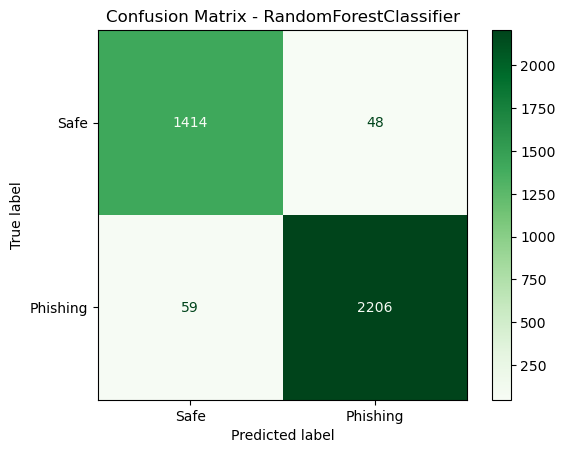

Best model for p=0.5: SVC


<Figure size 600x400 with 0 Axes>

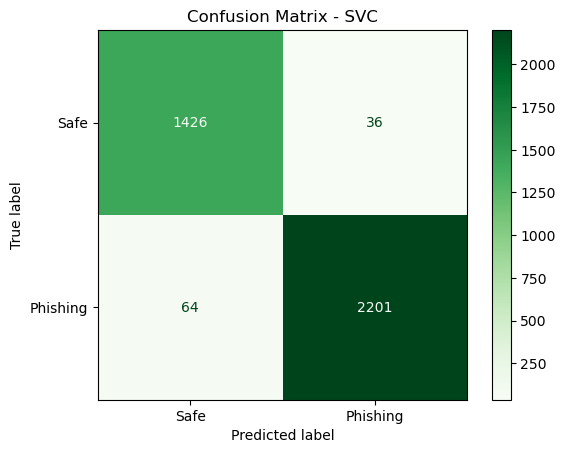

Best model for p=0.05: LogisticRegression


<Figure size 600x400 with 0 Axes>

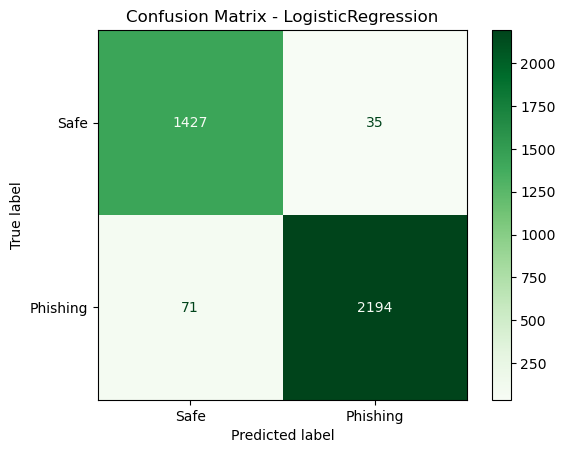

RandomForestClassifier SVC LogisticRegression


In [14]:
print(cf(confusion_matrices, p=0.95), cf(confusion_matrices, p=0.5), cf(confusion_matrices, p=0.05))

We observe that the decision-maker's preferred model varies significantly depending on their aversion to the two types of errors. It may therefore be useful to plot the cost function curve for each model as the parameter $p$ changes, in order to facilitate decision-making.

It is worth noting that a decision-maker is indifferent between using model 1 or model 2 if :

$$
FN_{\text{Model 1}} \times p + FP_{\text{Model 1}} \times (1-p) = FN_{\text{Model 2}} \times p + FP_{\text{Model 2}} \times (1-p)
$$

It's equivalent to :

$$
p = \frac{FP_{\text{M2}} - FP_{\text{M1}}}{(FN_{\text{M1}} - FP_{\text{M1}}) - (FN_{\text{M2}} - FP_{\text{M2}})}
$$

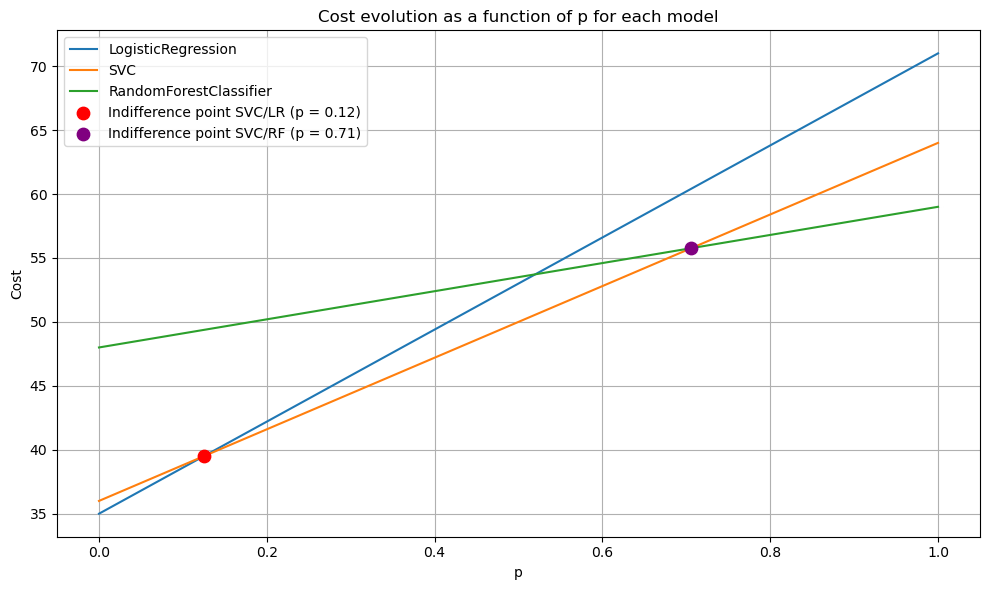

In [15]:
#Plotting the preference lines for each model

val_p = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 6))

for name, cm in confusion_matrices.items():
    fn = cm[1][0]
    fp = cm[0][1]
    scores = [p * fn + (1 - p) * fp for p in val_p]
    plt.plot(val_p, scores, label=name)

#1st indifference point

fnsvc = confusion_matrices['SVC'][1][0]
fpsvc = confusion_matrices['SVC'][0][1]
fnlr = confusion_matrices['LogisticRegression'][1][0]
fplr = confusion_matrices['LogisticRegression'][0][1]
p = (fpsvc - fplr) / ( (fnlr - fplr) - (fnsvc - fpsvc) )
plt.scatter(p, p * fnsvc + (1 - p) * fpsvc, c='red', s=80, zorder=5, 
            label=f"Indifference point SVC/LR (p = {round(p,2)})")

#2nd indifference point

fnrf = confusion_matrices['RandomForestClassifier'][1][0]
fprf = confusion_matrices['RandomForestClassifier'][0][1]
p = (fprf - fpsvc) / ( (fnsvc - fpsvc) - (fnrf - fprf) )
plt.scatter(p, p * fnsvc + (1 - p) * fpsvc, c='purple', s=80, zorder=5,
            label=f"Indifference point SVC/RF (p = {round(p,2)})")

plt.xlabel("p")
plt.ylabel("Cost")
plt.title("Cost evolution as a function of p for each model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Our graphical representation highlights that, in our case, a decision-maker who is highly averse to the risk of missed detection ($p > 0.71$) will prefer using the Random Forest model, which minimizes false negative errors. Other decision-makers who are highly averse to the risk of false alarms ($p < 0.12$) will favor the Logistic Regression model. Finally, decision-makers who are more neutral than the previous ones ($p \in [0.12, 0.71]$) will prefer using a Support Vector Machine model.

For one of our models (for example, Logistic Regression), let us focus on the words that have the greatest influence on predicting the nature of an email.

In [16]:
lr = best_models['LogisticRegression']

#Retrieval of words and associated coefficients

coefficients = lr.coef_[0]
words = vectorizer.get_feature_names_out()

#Words associated with phishing (negative coefficients)

top_phishing = sorted(zip(coefficients, words))[:10]

#Words associated with safe emails (positive coefficients)

top_safe = sorted(zip(coefficients, words), reverse=True)[:10]

print("Top 10 words associated with phishing e-mails:")
print(pd.DataFrame(top_phishing, columns=["Coefficient", "Word"]))

print("\nTop 10 words associated with safe emails:")
print(pd.DataFrame(top_safe, columns=["Coefficient", "Word"]))

Top 10 words associated with phishing e-mails:
   Coefficient       Word
0   -10.090262       2005
1    -8.492938  sightings
2    -7.007900     remove
3    -6.102538       2004
4    -5.827502      click
5    -5.627373    removed
6    -5.255633      money
7    -5.054120       free
8    -4.998672       life
9    -4.978196      email

Top 10 words associated with safe emails:
   Coefficient        Word
0    14.085926       enron
1    10.117766         url
2    10.110544       wrote
3     8.841197        2002
4     8.322817      thanks
5     7.670749    language
6     7.185944       vince
7     7.020811         edu
8     6.827990  university
9     6.788313    attached
